# 45-Minute Diffusion & Flow Exercise

This exercise demonstrates diffusion + convection and simple hemodynamics (Normal, Valsalva, Fibrosis, Combined). Run cells in order. Plots will be shown inline when possible.

## 🎯 Learning Objectives
- Understand diffusive and convective flux.
- Explore physiological impacts on solute transport.
- Implement and interpret the Peclet number.
- Practice writing scientific notes.

## 📚 Background & Theory

Solute transport is governed by:
- **Diffusion**: driven by concentration gradients.
- **Convection**: driven by fluid flow.


## Part A — Quick diffusion timescales
Compute timescale for diffusion across different tissuethicknesses, with lengths of 1 µm and 1 mm.
Use the following equation:
$$t = x^2/(2D)$$
with $D = 1.8e-3 mm^2/s$ for $O_2$-diffusion coefficient.

- What is the timescales for the two different tissue thicknesses 1 µm and 1 mm?
- Assume a timescale greater than 2 ms is too large for effecient diffusion of $O_2$, if only considering diffusion, what thickness is diffusion no longer viable?


In [50]:
# %load diffusion_time.py
import math

D = 1.8e-3  # m^2/s, sammme som 1.8e-5 cm^2s^-1
x1 = 1e-3
x2 = 1

# Solution

## Part B — Fick + Convection (analytic steady 1D solution)


If we know the boundary conditions, the equation for Concentration (C) can be calculated using the following equation

$$ C(x) = C_0 + (C_L - C_0)\frac{e^{v x / D} - 1}{e^{v L / D} - 1} $$



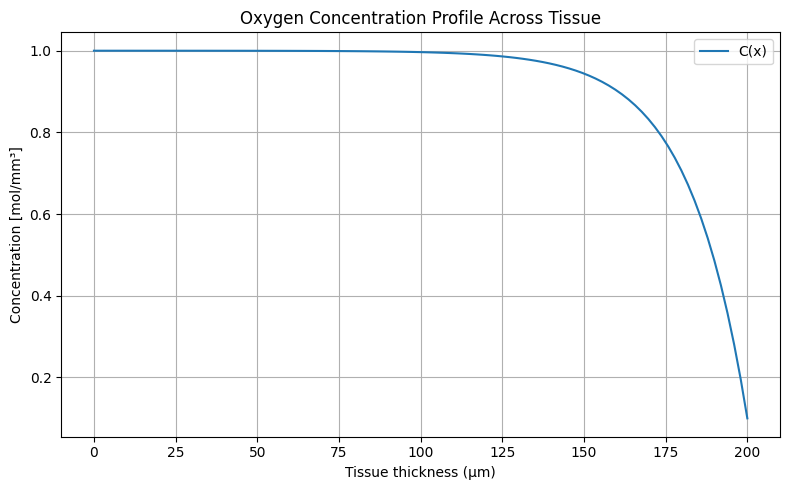

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
C0 = 1.0  # mol/mm^3
CL = 0.1  # mol/mm^3
L = 0.2  # mm
v = 0.1  # mm/s
D = 1.8e-3  # mm^2/s

# Create position array from 0 to L
x = np.linspace(0, L, 100)

# Compute concentration profile using analytical solution
C = C0 + (CL - C0) * np.expm1(v * x / D) / np.expm1(v * L / D)

# Plot the concentration profile
plt.figure(figsize=(8, 5))
plt.plot(x * 1e3, C, label="C(x)")
plt.xlabel("Tissue thickness (μm)")
plt.ylabel("Concentration [mol/mm³]")
plt.title("Oxygen Concentration Profile Across Tissue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




However, if we do not know the boundary conditions, or if the flow is diffusion dominated, we may use the differential equation $-D \frac{d^2C}{dx^2} + v \frac{dC}{dx} = 0$, which integrates into an exponential decay model:

$$ C(x) = C_0 * e^{\frac{-x}{\lambda_{eff}}} $$

where $\lambda_{eff} = \sqrt{2 D \Delta t}$ and $\Delta t = \frac{L_{axial}}{v}$. 

### Flux 
We can use the steady 1D convection–diffusion equation to calculate flux:
    
$$ 
J_s = -D \frac{\partial C(x,t)}{\partial x} + J_v C(x,t) 
$$

**In the python code below:**
- Describe what model used in the function `concentration(...)`?
- What is the assumption for using the function `concentration(...)`?
- Describe how J_s is being calculated

****


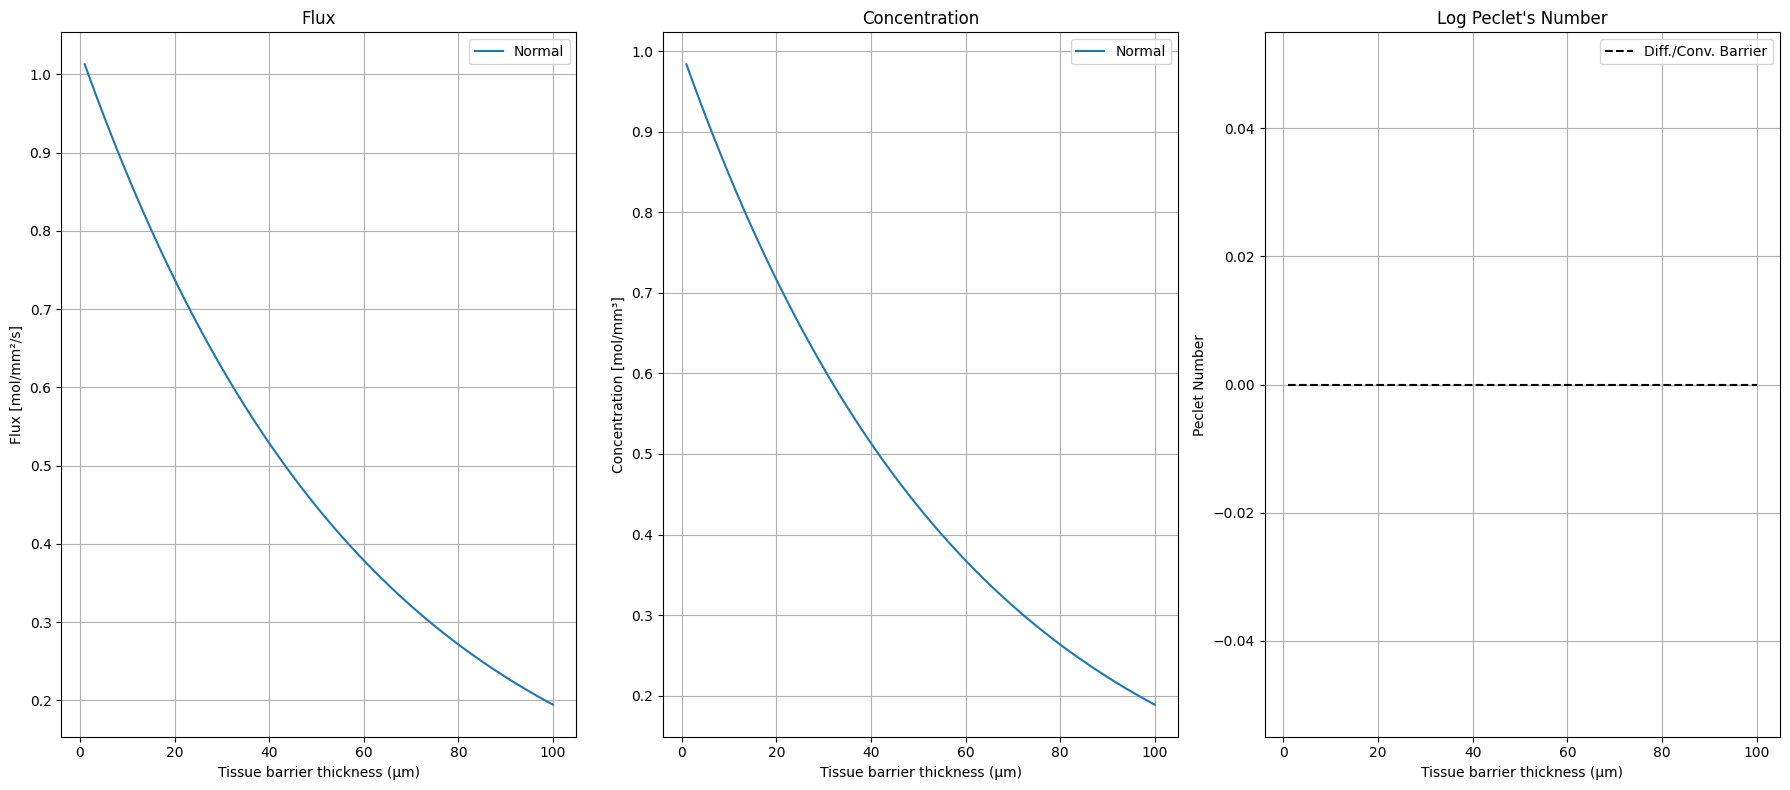

In [52]:
# %load flux_model_init.py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes


def concentration(x, L_axial, v, D, C0):
    transit_time = L_axial / v
    lambda_eff = np.sqrt(2 * D * transit_time)
    C = C0 * np.exp(-x / lambda_eff)
    return C


def flux(
    x: np.ndarray,
    C: np.ndarray,
    v: float,
    D: float,
):
    dCdx = np.gradient(C, x)
    Jd = -D * dCdx
    Jc = v * C
    Js = Jd + Jc

    return Js


if __name__ == "__main__":
    import matplotlib.pyplot as plt

    L_axial = 1  # mm
    L = 0.1  # mm
    C0 = 1.0  # mol/mm^3
    x = np.linspace(0.01 * L, L, 101)  # mm

    conditions = {
        "Normal": {
            "v": 1,
            "D": 1.8e-3,
        },  # Normal Scenario, add new lines with different scenarios
    }
    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 8))
    axs: list[matplotlib.axes.Axes]

    for i, (label, params) in enumerate(conditions.items()):
        v = params["v"]
        D = params["D"]

        # Flux components
        C = concentration(x, L_axial, v, D, C0)
        Js = flux(x, C, v, D)

        # Plot fluxes
        axs[0].plot(x * 1e3, Js, label=label)
        axs[0].set_title("Flux")
        axs[0].set_xlabel("Tissue barrier thickness (μm)")
        axs[0].set_ylabel("Flux [mol/mm²/s]")
        axs[0].grid(True)
        axs[0].legend()

        # Plot concentration
        axs[1].plot(x * 1e3, C, label=label)
        axs[1].set_title("Concentration")
        axs[1].set_xlabel("Tissue barrier thickness (μm)")
        axs[1].set_ylabel("Concentration [mol/mm³]")
        axs[1].grid(True)
        axs[1].legend()

        # Plot peclet
        if i == 0:
            axs[2].plot(
                x * 1e3,
                np.zeros_like(x),
                label="Diff./Conv. Barrier",
                linestyle="--",
                color="k",
            )

        axs[2].set_title("Log Peclet's Number")
        axs[2].set_xlabel("Tissue barrier thickness (μm)")
        axs[2].set_ylabel("Peclet Number")
        axs[2].grid(True)
        axs[2].legend()

    plt.tight_layout()
    plt.show()



## 🧠 Physiological Scenarios in the Convection-Diffusion Model

The model is used to simulate solute transport across tissue barriers includes two key parameters:

- **\( v \)**: velocity of fluid flow (e.g., interstitial or capillary flow)
- **\( D \)**: diffusion coefficient of the solute (e.g., oxygen)

These parameters determine how solute concentration changes across the tissue. We are now going to simulate two scenarios.
1. Valsalva Maneuver
2. Fibrosis


Extend the model to include three new conditions:

- **Valsalva**: `v = 3 mm/s`, `D = 1.8e-3 mm²/s`
- **Fibrosis**: `v = 1 mm/s`, `D = 0.9e-3 mm²/s`
- **Valsalva + Fibrosis**: `v = 3 mm/s`, `D = 0.9e-3 mm²/s`


### ❓ Question

**What happens to the solute transport in each case?**  

**What effect does this have on oxygen delivery to deeper tissue?**



### 🫁 Valsalva Maneuver

**Valsalva** is a forced exhalation against a closed airway, often used in clinical tests. It increases **intrathoracic pressure**, which can affect blood and interstitial flow.
In this task, you will extend the solute transport model to simulate the **Valsalva Maneuver**, a physiological condition that increases intrathoracic pressure and fluid velocity.


- **Effect on \( v \)**: ↑ Increased velocity due to pressure-driven flow
- **Effect on \( D \)**: No direct change, but tissue compression may slightly alter diffusion



### 🧬 Fibrosis

**Fibrosis** is the thickening and scarring of connective tissue, often due to chronic inflammation or disease.

- **Effect on \( D \)**: ↓ Reduced diffusion due to dense extracellular matrix
- **Effect on \( v \)**: May be unchanged or slightly reduced due to restricted flow


### 🔍 Valsalva + Fibrosis

- \( v \): ↑ Increased
- \( D \): ↓ Decreased

---




## ✅ Answer

#### 🔬 Valsalva
- **Higher velocity** increases convection.
- Concentration drops steeply near the inlet.
- Flux increases due to stronger convective transport.
- Convection dominates → Peclet number increases
- **Oxygen delivery is fast but shallow** — less reaches deeper tissue.

#### 🔬 Fibrosis
- **Lower diffusion** restricts solute spread.
- Concentration decays more sharply.
- Flux decreases due to reduced diffusive component.
- Lower \( D \) → slower diffusion → steeper concentration drop
- Peclet number increases → convection appears more dominant even if flow is unchanged
- This can lead to **poor oxygen penetration**, especially in deeper or hypoxic regions.
- **Oxygen delivery is impaired**, especially in distal regions.

#### 🔬 Valsalva + Fibrosis
- **High velocity + low diffusion** creates extreme gradient.
- Concentration drops very steeply.
- Flux is dominated by convection, but diffusion is minimal.
- Very high Peclet number
- Strong convection, weak diffusion
- Concentration drops sharply near the inlet, with little oxygen reaching the far end
- **Oxygen is swept quickly but poorly distributed**, risking hypoxia in deeper tissue.


###  Summary Table

| Condition           | \( v \) | \( D \) | Concentration Profile | Flux Behavior | Oxygen Delivery |
|---------------------|--------|--------|------------------------|----------------|------------------|
| Normal              | 1      | 1.8e-3 | Moderate decay         | Balanced       | Effective        |
| Valsalva            | 3      | 1.8e-3 | Steep decay            | ↑ Convective   | Shallow delivery |
| Fibrosis            | 1      | 0.9e-3 | Steep decay            | ↓ Diffusive    | Impaired         |
| Valsalva + Fibrosis | 3      | 0.9e-3 | Very steep decay       | ↑↑ Convective, ↓ Diffusive | Poor deep delivery |




### Peclet's Number
The Péclet number (Pe) is a dimensionless quantity representing the ratio of transport by convection (advection) to transport by diffusion, and for oxygen transfer from blood to a cell, it can be generally expressed as 
$$Pe = \frac{v * L}{D}$$

Here, '$v$' is the characteristic fluid velocity (e.g., red blood cell velocity or plasma flow velocity), '$L$' is a characteristic length scale (such as the capillary radius or cell size), and '$D$' is the diffusion coefficient of oxygen in the surrounding medium (e.g., plasma or tissue). 
A high $Pe$ value, where convection dominates, means oxygen is quickly transported by the flow, while a low value indicates diffusion is the primary transport mechanism


### Interpretation for Oxygen Transfer
- **Pe > 1 (Convection-Dominated):**
    When the Peclet number is significantly greater than 1, it signifies that the rate at which oxygen is transported by the fluid's bulk flow (convection) is much faster than its transport due to concentration gradients (diffusion). In this regime, the movement of oxygen is primarily dictated by the fluid's movement. 
- **Pe < 1 (Diffusion-Dominated):** 
    If the Peclet number is less than 1, diffusion becomes the dominant process for oxygen transport. The movement of oxygen is driven by its tendency to spread from areas of high concentration to areas of low concentration. 
- **Pe ≈ 1 (Mixed Regimes):**
    In situations where the Peclet number is around 1, both convection and diffusion are important and contribute to the overall transport of oxygen. 


### Example Application

- Microchannel studies: have shown that for small channel heights and high flow rates, the Péclet number is large, indicating that advection (convection) is the primary mode of oxygen transport. 
- In the microvascular system, the flow of blood and red blood cells moves oxygen towards the tissues. The Péclet number helps determine if the rate of delivery by this flow is sufficient to meet the metabolic demand of the tissue, or if diffusion-limited transport becomes the bottleneck. 

### Algebraic Solution

Assume that we are working with transfer of Oxygen, where $D=1.8e-3 mm^2/s$.
Add a model that describes Peclet's number as a function of tissue depth for the 4 scenarios above.

- Make a model that calculates Peclet's number
- Plot for each of the 4 scenarios above, peclets number on the approiate axes. 